Todo:<br>
stratify sampling<br>
~PCA~<br>
check time dependent info<br>
if feature sparse<br>
cross validation<br>

# Colab Setting


In [ ]:
import os
from google.colab import drive
# mount Google drive
drive.mount('/content/drive')


# by default everything gets executed and saved in 'Berkeley Capstone (Students)'
# notebook_path = '/content/drive/MyDrive/Berkeley Capstone (Students)/Code' # WK
notebook_path = '/content/drive/MyDrive/Capstone/Berkeley Capstone (Students)/Code/InsDetek3.0_LSTM' # GQ
os.chdir(notebook_path)

# !echo -e "\nCurrent directory:"
# !pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm, trange
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
import re

import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from dataloader_ import df_to_tensor


# Read Data

In [ ]:
# df = pd.read_csv('data/week_norm_all.csv') # Norm
# df = pd.read_csv('data/week_norm_pca.csv') # Norm, PCA
# df = pd.read_csv('week_norm_pca_70.csv') # Norm, PCA, Delted 70% clean(72,0)
# df = pd.read_csv('data/data_redist_short_aug1_del1_norm_PCA.csv', index_col='idx').drop('week', axis=1)
df = pd.read_csv('data/data_3.1.csv', index_col='idx')
df = df.drop('week', axis=1)

# df = pd.read_csv('data/data_3.1_sf.csv')
df

,user,n_allact,allact_n-pc0,allact_n-pc1,allact_n-pc2,allact_n-pc3,n_workhourallact,workhourallact_n-pc0,workhourallact_n-pc1,workhourallact_n-pc2,...,weekendhttp_jobf_mean_http_c_len,weekendhttp_jobf_mean_http_c_nwords,weekendhttp_jobf_n-pc0,weekendhttp_n_leakf,weekendhttp_leakf_mean_url_len,weekendhttp_leakf_mean_url_depth,weekendhttp_leakf_mean_http_c_len,weekendhttp_leakf_mean_http_c_nwords,weekendhttp_leakf_n-pc0,insider
idx,,,,,,,,,,,,,,,,,,,,,
17822,4.00,-1.413080,-1.403029,-0.164752,-0.162994,-0.043623,-1.368535,-1.356573,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
18801,4.00,-1.409682,-1.399599,-0.164752,-0.162994,-0.043623,-1.357743,-1.345797,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
19777,4.00,-1.409682,-1.399599,-0.164752,-0.162994,-0.043623,-1.357743,-1.345797,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
20752,4.00,-1.457248,-1.447616,-0.164752,-0.162994,-0.043623,-1.411703,-1.399677,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
21727,4.00,-1.409682,-1.399599,-0.164752,-0.162994,-0.043623,-1.357743,-1.345797,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51624,983.12,0.176965,0.202113,-0.164752,-0.162994,-0.043623,0.347404,0.356799,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
52506,983.12,0.166773,0.191824,-0.164752,-0.162994,-0.043623,0.336612,0.346023,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0
53386,983.12,0.248313,0.274139,-0.164752,-0.162994,-0.043623,0.261067,0.270592,-0.155259,-0.076973,...,-0.064855,-0.06509,-0.043475,-0.043138,-0.043138,-0.043138,-0.041869,-0.041897,-0.043138,0


## Split

In [ ]:
user_list = df['user'].unique()
user_train, user_test = train_test_split(user_list, train_size = 0.8, shuffle = True)
user_valid, user_test = train_test_split(user_test, train_size = 0.3, shuffle = True)
print('train:', len(user_train), 'users\n', 'test:', len(user_valid), 'users\n', 'valid:', len(user_test), 'users')

train_df = df[df['user'].isin(user_train)]
valid_df = df[df['user'].isin(user_valid)]
test_df = df[df['user'].isin(user_test)]
print('train:', train_df.shape, '\n', 'test:', valid_df.shape, '\n', 'valid:', test_df.shape)

train: 614 users
 test: 46 users
 valid: 108 users
train: (15284, 405) 
 test: (1211, 405) 
 valid: (2886, 405)


In [ ]:
batch_size = 32
# data_loader = df_to_tensor(df, batch_size, all_label = False, print_summary = True)
data_loader_train = df_to_tensor(train_df, batch_size, all_label = True, print_summary = True, shuffle = True)
data_loader_valid = df_to_tensor(valid_df, batch_size, all_label = True, print_summary = True, shuffle = True)
data_loader_test = df_to_tensor(test_df, batch_size, all_label = True, print_summary = True, shuffle = True)

==== DataFrame to DataLoader ====
Input DataFrame: (15284, 405)
   => 614 sequences (614 users)
       features in size of [(max) length, dimension] = torch.Size([43, 403])
       labels in size of [(max) length, dimension] = torch.Size([43])
   => output DataLoader: 20 batches (batchsize = 32)
       features in size of [batchsize, (max) length, dimension] = torch.Size([32, 42, 403])
       labels in size of [batchsize, (max) length] = torch.Size([32, 40])
       masks in size of [batchsize, (max) length] = torch.Size([32, 36])
==== DataFrame to DataLoader ====
Input DataFrame: (1211, 405)
   => 46 sequences (46 users)
       features in size of [(max) length, dimension] = torch.Size([40, 403])
       labels in size of [(max) length, dimension] = torch.Size([40])
   => output DataLoader: 2 batches (batchsize = 32)
       features in size of [batchsize, (max) length, dimension] = torch.Size([32, 40, 403])
       labels in size of [batchsize, (max) length] = torch.Size([32, 44])
       

# Model

## LSTM structure

In [ ]:
class LSTMTagger(nn.Module):

    def __init__(self, input_size, tagset_size, batch_size):
        super(LSTMTagger, self).__init__()
        self.conv1 = torch.nn.Conv1d(input_size, 256, kernel_size = 1) # [bs, f, seq] → [bs, 128, seq]
        # why not conv on feature dim
        self.conv2 = torch.nn.Conv1d(256, 128, kernel_size = 1) # [bs, f, seq] → [bs, 128, seq]
        self.lstm = nn.LSTM(128, 64, batch_first = True)
        self.hidden1 = nn.Linear(64, 32)
        self.hidden2 = nn.Linear(32, 8)
        self.hidden2tag = nn.Linear(8, tagset_size)


    def forward(self, input):
        self.input_seq = input.permute(0,2,1) # to [batchsize, feature, seq]
        self.cnn_out1 = self.conv1(self.input_seq)        
        self.cnn_out2 = self.conv2(self.cnn_out1)
        self.cnn_out2 = self.cnn_out2.permute(0,2,1) # to [batchsize, seq, feature]
        self.lstm_out, (self.hidden, self.cell) = self.lstm(self.cnn_out2)
        hidden1_out = self.hidden1(self.lstm_out)
        hidden2_out = self.hidden2(hidden1_out)
        logit = self.hidden2tag(hidden2_out)
        prob_log = F.log_softmax(logit, dim=1)
        return prob_log

In [ ]:
def predict_using(network):
    def predictor(raw_data):
        """Return a list of part-of-speech tags as strings, one for each word.

        raw_data - a list of (word, tag) pairs.
        """
        tags = []

        with torch.no_grad(): # turns off automatic differentiation, which isn't required but helps save memory

            # YOUR CODE HERE

            # * put `network` into evaluation mode (turning off dropout) using `.eval()`
            #   then back into train mode at the end of the function with `.train()`
            #   this is easy to forget and could lead to lower accuracy without warning
            #   see https://pytorch.org/docs/stable/_modules/torch/nn/modules/module.html#Module.train for more info
            network.eval()

            for feature_seqs, label_seqs, mask_seqs in tqdm(data_loader_valid):
                #  * run `network` to get outputs
                logits = network(feature_seqs, mask_seqs)
                #  * get the id of the predicted part of speeches with an argmax operation
                output_ind = F.softmax(logits, dim=1).argmax(dim=-1)
                # ipdb.set_trace()
                # print(output_ind.shape)
                #  * convert the predictions to strings using `all_tags`
                # output = all_tags[output_ind]
                output_ind = output_ind.detach().cpu().numpy()
                all_tags_ = np.array(all_tags)
                actual_out = np.take_along_axis(all_tags_, output_ind, axis = 0)
                # ipdb.set_trace()
                tags.append(actual_out)
        # * return your predictions
        print(len(tags))
        return tags
        
    return predictor

# The predictions of an untrained model should be arbitrary.
# print_sample_predictions(predict_using(untrained_baseline), validation_data_raw)

## hyperparam & model

In [ ]:
### PARAMETERS ###
# seq_len = batch_shape[1] # it's changing!!!
input_size = 403 # dimension of features
# hidden_size = 16 # 
num_layers = 1 # 
num_class = 2 # 0/1

### MODEL ###
model = LSTMTagger(input_size, num_class, batch_size)
# loss_function = nn.NLLLoss(reduction = 'none') 
weight = torch.tensor([1.5, 5])
# weight = torch.tensor([1.0,4,4,7])
loss_function = nn.NLLLoss(weight, reduction = 'none') 
#focal loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
before = dict(model.state_dict())

# Train

In [ ]:
def train(model, epoch, data_loader, optimizer, loss_function):
    epoch_bar = tqdm(range(epoch), leave = True)
    loss_list = []
    gradient_list = []
    for epoch in epoch_bar:  
        batch_bar = tqdm(data_loader, leave = False)
        loss_list_epoch = []
        for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar): # get feature sequenceS, label sequenceS and mask sequenceS

            # == Step 1. clear gradient ==
            model.zero_grad()
            

            # == Step 2. Run forward pass ==
            predict_seqs = model(feature_seqs)

            # == Step 3.1 Compute the loss ==
            seq_len = feature_seqs.shape[1] 
            predict_seqs = predict_seqs.reshape([-1,num_class,seq_len])
            # [20,72,2]→[20,2,72] Because the input of NLLLoss is in (C,N_class, d1, d2, ...)
            # print('predict_seqs.shape', predict_seqs.shape)
            # print('label_seqs.shape',label_seqs.shape)
            loss = loss_function(predict_seqs, label_seqs) # loss.shape = [batchsize, seq_len] = [20,72]
            loss = torch.mul(loss, mask_seqs).reshape(-1).mean()

            # 首先是不是要scores和label size相同，都onehot或者都不
            # 其次，如果我补零补的是label里没有出现大的-1， 那tagset_size是不是就要从2变成3？是不是要多一类出来？


            # == Step 3.2 Compute the gradients ==
            loss.backward()
            # == Step 3.3 Update the parameters ==

            # [0:'lstm.weight_ih_l0', 1:'lstm.weight_hh_l0', 2:'lstm.bias_ih_l0', 3:'lstm.bias_hh_l0', 4:'hidden2tag.weight', 5:'hidden2tag.bias']
            # p_i = 0
            # print('batch', batch_i, params_name[p_i], optimizer.param_groups[0]['params'][p_i].shape, optimizer.param_groups[0]['params'][p_i].grad)
            # gradient_list.append(optimizer.param_groups[0]['params'][p_i].grad.numpy().tolist()) # need to add .numpy().tolist(), otherwise the grad value is changable, may saved the address
            
            # para_before = model.state_dict()['lstm.weight_ih_l0']
            optimizer.step()
            # if not model.state_dict()['lstm.weight_ih_l0'].equal(para_before):
            #     print('param changed')

            batch_bar.set_description('batch: %i' % batch_i)
            batch_bar.set_postfix(loss=format(loss,'.3f'))
            loss_list_epoch.append(loss)
        loss_list.append(loss_list_epoch)
        epoch_bar.set_description('Epoch: %i' % epoch)
    return loss_list

In [ ]:
loss_list = train(model, 300, data_loader_train, optimizer, loss_function)

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
lis = [1,2,3]
dff = pd.DataFrame(columns = ['a','b'])
a, b = [], []
for i, l in enumerate(lis):
    a.append(i)
    b.append(l)
dff['b'] = list(range(len(lis)))+lis
dff['a'] = 12
dff

,a,b
0,12,0
1,12,1
2,12,2
3,12,1
4,12,2
5,12,3


In [ ]:
len(loss_list[0])

1

In [ ]:
epoch_loss = []
loss_df = pd.DataFrame(columns = ['epoch', 'batch', 'loss'])
for i, epoch_i_loss in enumerate(loss_list):
    epoch_loss = []
    # print(epoch_i_loss)
    for batch_j_loss in epoch_i_loss:
        epoch_loss.append(float(batch_j_loss.detach().numpy()))
    df_temp = pd.DataFrame(columns = ['epoch', 'batch', 'loss'])
    df_temp['batch'] = list(range(len(epoch_i_loss)))
    df_temp['epoch'] = float(i)    
    df_temp['epoch'] = df_temp['epoch'].astype(float)
    # print(df_temp)
    df_temp['loss'] = epoch_loss
    loss_df = loss_df.append(df_temp)
loss_df

,epoch,batch,loss
0,0.0,0,3.099520
1,0.0,1,3.130600
2,0.0,2,3.193280
3,0.0,3,3.503949
4,0.0,4,3.694817
...,...,...,...
15,299.0,15,3.673168
16,299.0,16,4.057213
17,299.0,17,3.821891
18,299.0,18,3.217278


In [ ]:
px.colors.sequential.gray

['rgb(0, 0, 0)',
 'rgb(16, 16, 16)',
 'rgb(38, 38, 38)',
 'rgb(59, 59, 59)',
 'rgb(81, 80, 80)',
 'rgb(102, 101, 101)',
 'rgb(124, 123, 122)',
 'rgb(146, 146, 145)',
 'rgb(171, 171, 170)',
 'rgb(197, 197, 195)',
 'rgb(224, 224, 223)',
 'rgb(254, 254, 253)']

In [ ]:
batches = 20
color_list = ['rgb({0}, {0}, {0})'.format(int(i/batches*255)) for i in range(batches, 0, -1)]

In [ ]:
# fig = px.line(loss_df[loss_df['epoch']%10 == 0], x = 'batch', y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig = px.line(loss_df, x = 'batch', y = 'loss', color = 'epoch', color_discrete_sequence= color_list)
fig.update_layout(plot_bgcolor='#a1afc9')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [ ]:
px.line(loss_df.groupby('epoch').mean().reset_index(), x = 'epoch', y = 'loss')

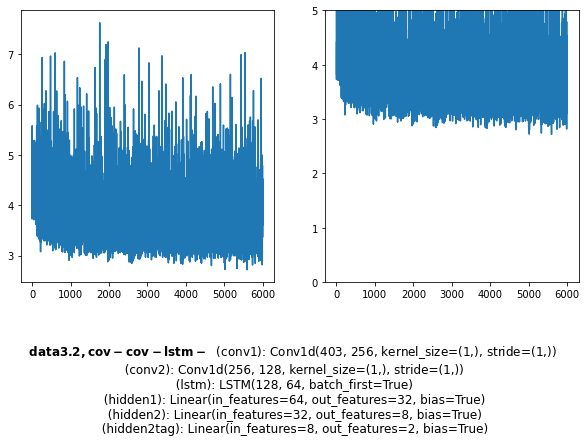

In [ ]:
_ = loss_plot(loss_list, save=False)

In [ ]:
loss_list[21].grad

NameError: ignored

[3.8995280265808105,
 3.52017879486084,
 3.2528133392333984,
 3.6374824047088623,
 3.9586222171783447,
 3.695587158203125,
 4.6442975997924805,
 3.8397159576416016,
 3.4472196102142334,
 3.609076738357544,
 4.08482551574707,
 3.5579826831817627,
 3.568781852722168,
 3.251960277557373,
 3.6041884422302246,
 3.626244306564331,
 3.236480951309204,
 3.705892324447632,
 4.358091354370117,
 6.593587875366211]

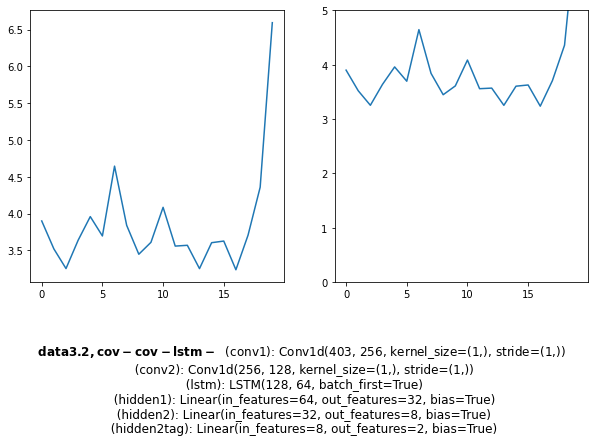

In [ ]:
temp = []
loss_df = pd.Series(loss_list)
for i in range(100):
    temp.append(loss_list.iloc[:,20*60+i])
loss_plot(temp, False)

# Search - loss weight

In [ ]:
weight_list = torch.tensor([[1.5, 5], [1.5,6], [1,6], [0.1,0.9],[0.01,0.99]])
for weight in weight_list:
    print('=== ',weight,' ===')
    loss_function = nn.NLLLoss(weight, reduction = 'none') 
    loss_list = train(model, data_loader, optimizer, loss_function)
    _ = loss_plot(loss_list, False)
    predictor = Predictor(model, df)
    predictor.get_metrics()

# Results

In [ ]:
# # to change default colormap
# plt.rcParams["image.cmap"] = "Set1"
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

In [ ]:
def write_log(exp_n, comment):
    exp = str(exp_n).zfill(3)
    path = 'log/exp' + exp + '/'
    if os.path.exists(path):
        print("=== Overwriting!!! ===")
    else:
        os.makedirs(path)   

    with open("log/log.txt","a") as f:
        f.write('\r\n\r\n' + exp)
        f.write('\r\n\t' + comment)

    dic = {'model':model, 'optim':optimizer}
    torch.save(dic, path +'model_optim.pth')

    print(path)
    return path


In [ ]:
info =  '==== model info ====\n'\
        + 'batchsize=' + str(batch_size)\
        + '\n' + 'optim=' + optimizer.__class__.__name__\
        + '(lr={:g})'.format(optimizer.param_groups[0]['lr'])
print(info)
comment = """
data3.1.csv
100 epochs lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2
""" + info

==== model info ====
batchsize=32
optim=Adam(lr=0.0001)


In [ ]:
exp_nums = re.findall('\d{3}', str(os.listdir('log')))
exp_new = max(list(map(lambda x: int(x), exp_nums))) + 1

In [ ]:
path = write_log(exp_new, comment)

log/exp029/


## Loss

In [ ]:
def loss_plot(loss_list, save=True):
    losslist = []
    for i in loss_list:
        losslist.append(float(i.detach().numpy()))
    note = '\n $\mathbf{data3.2, cov-cov-lstm-}$'
    plt.figure(figsize = (10,5))
    plt.suptitle(note + re.findall('LSTMTagger\(\\n(.+)\\n\)$',str(model), re.S)[0], y = -0.001)
    plt.subplot(1,2,1)
    plt.plot(losslist)
    plt.subplot(1,2,2)
    plt.plot(losslist)
    plt.ylim(0,5)
    if save:
        plt.savefig(path + 'loss.jpg', bbox_inches='tight')
    return losslist
# losslist = loss_plot(loss_list)

In [ ]:
loss_df = pd.DataFrame(losslist)#.reset_index(drop=False)
loss_df.columns = ['loss']#['epoch', 'loss']
loss_df.to_csv(path+'loss.csv', index = False)

In [ ]:
# save
# torch.save(dic, path +'model_optim.pth')
# load
# net = torch.load('.pth')
# net['model'].state_dict()

# log

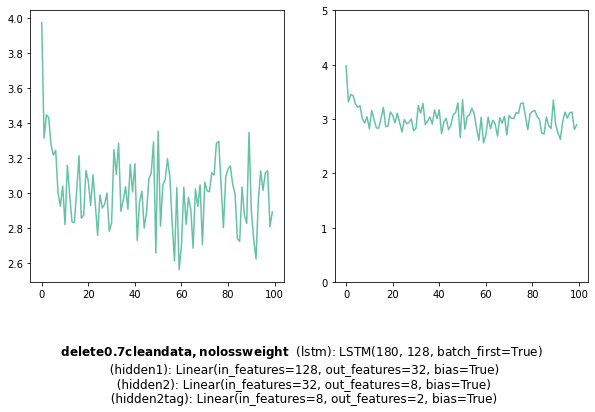

0.9, 0.1
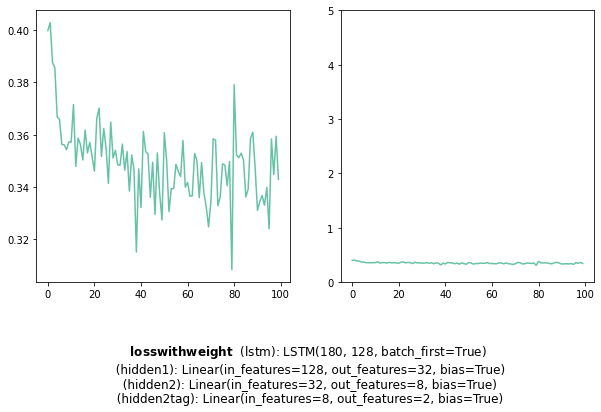

## ep - bc=32

In [ ]:
loss1 = pd.read_csv('./log/normall_lstm_bc50_adam_nll.csv')['loss']
loss2 = pd.read_csv('./log/normall_lstm_hidden_bc32_adam_nll.csv')
loss3 = pd.read_csv('./log/normall_lstm32_hidden16_bc32_adam_nll.csv')
loss4 = pd.read_csv('./log/normall_lstm32_bc32_adam_nll.csv')
loss5 = pd.read_csv('./log/normall_lstm8_bc32_adam_nll.csv')
loss6 = pd.read_csv('./log/normall_lstm16_bc32_adam_nll.csv')
loss7 = pd.read_csv('./log/normall_lstm16_bc50_adam_nll(1).csv')

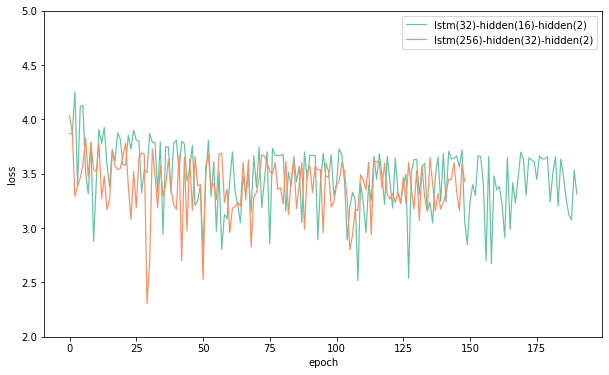

In [ ]:
# note = '\n $\mathbf{with mask, with norm}$'
# plt.figure(figsize = (10,5))
# plt.suptitle(info.split('\n')[-1]+'  batchsize = {:d}'.format(batch_size)+note)
# plt.subplot(1,2,1)
plt.figure(figsize = [10,6])
# plt.plot(loss1, label = 'lstm(16)-hidden(2)')
plt.plot(loss3, label = 'lstm(32)-hidden(16)-hidden(2)', linewidth=1.2)
plt.plot(loss2, label = 'lstm(256)-hidden(32)-hidden(2)', linewidth=1.2)
# plt.plot(loss4, label = 'lstm(32)-hidden(2)', linewidth=1.2)
# plt.plot(loss6, label = 'lstm(16)-hidden(2)', linewidth=1.2)
# plt.plot(loss5, label = 'lstm(8)-hidden(2)', linewidth=1)
# plt.plot(loss7, label = 'lstm(16)-hidden(2)-bc50', c = 'b', linewidth=0.7)
plt.ylim(2,5)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('./log/'+name+'.jpg')
# 要网格搜索 batchsize和lstm hidden这些

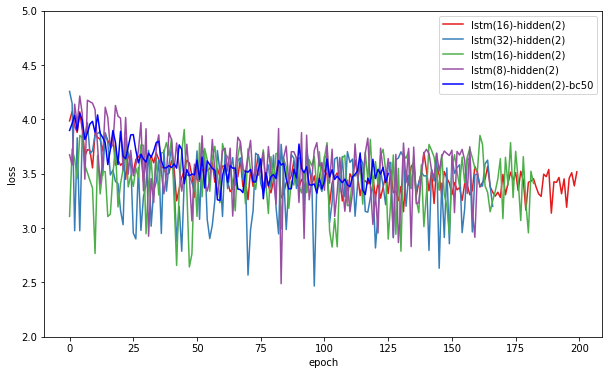

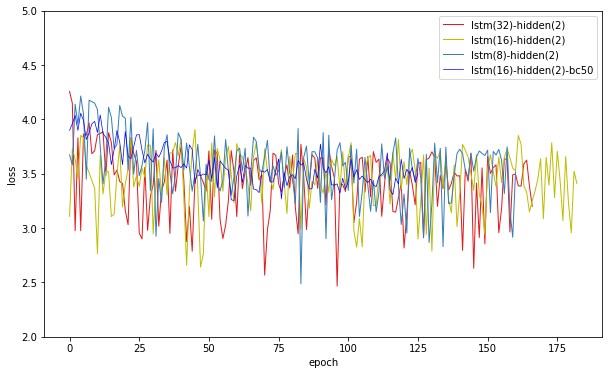

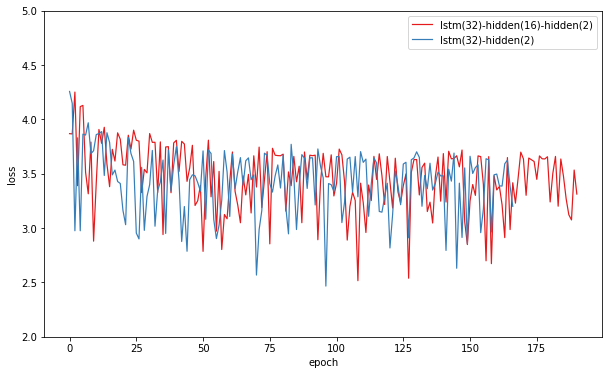

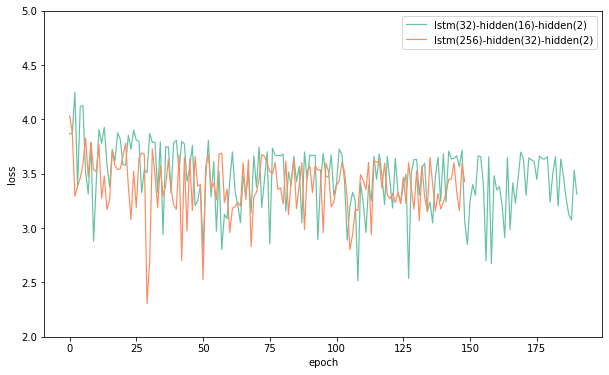

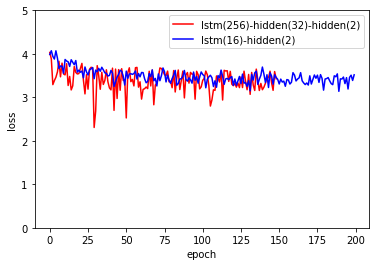

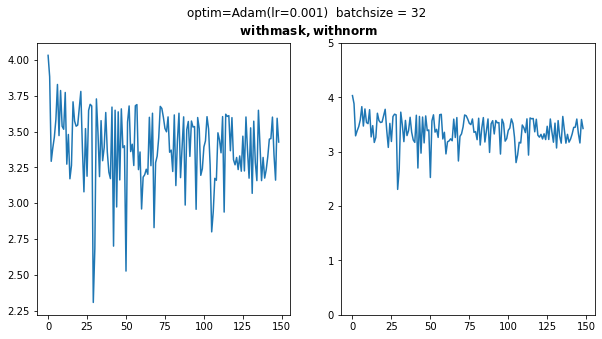

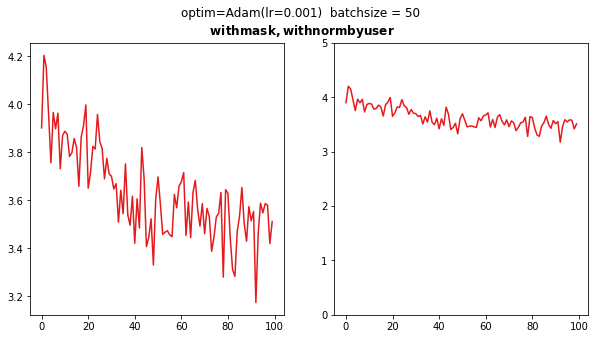

# Predict

In [ ]:
def
    batch_bar = tqdm(data_loader_valid, leave = True)
    predictions = []
    for batch_i, (feature_seqs, label_seqs, mask_seqs) in enumerate(batch_bar):
        seq_len = feature_seqs.shape[1]
        logits = model(feature_seqs) 

        label_flat = label_seqs.reshape(batch_size*seq_len, 1).tolist()
        output_flat = logits.reshape(batch_size*seq_len, num_class).tolist()
        index = int(mask_seqs.sum())
        pred = pd.DataFrame(output_flat[:index]).idxmax(axis=1).tolist()
        labels = pd.DataFrame(label_flat[:index]).idxmax(axis=1).tolist()
        predictions = predictions + pred
        break

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
pre, rec, f1, sup = precision_recall_fscore_support(labels, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(array([1., 0.]),
 array([0.53902439, 0.        ]),
 array([0.70047544, 0.        ]),
 array([820,   0]))

In [ ]:
ff = torch.tensor([ # batchsize=4
      [[25,15,32],  #d1
       [26,16,33]], #d2
      [[23,1,52],
       [0,0,0]],
      [[23,1,52],
       [21,23,24]],
      [[3,1,2],
       [1,2,2]],    
])
mm = torch.tensor([
      [1,1],
      [1,0],
      [1,1],
      [1,1]
], dtype = torch.bool)
mm.size()
ff[mm]

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import roc_curve, auc, recall_score, precision_recall_curve, classification_report
import matplotlib.pyplot as plt

all_tags = {0: 0, 1: 1}
pre_batch_size = 1 ###
class Predictor():
    def __init__(self, model, raw_data):
              self.model = model
              self.raw_data = raw_data
              
    
    def predictor(self):
        """Return a list of part-of-speech tags as strings, one for each word.

        raw_data - a list of (word, tag) pairs.
        """

        with torch.no_grad(): # turns off automatic differentiation, which isn't required but helps save memory

            model.eval()
            loader = df_to_tensor(self.raw_data, batch_size = pre_batch_size, all_label = True, print_summary = False)

            predictions = []
            for batch in loader:
                feature_seqs, label_seqs, mask_seqs = batch

                seq_len = feature_seqs.shape[1]
                logits = self.model(feature_seqs) 
                output_distribution = logits.reshape(pre_batch_size*seq_len, num_class).tolist()
                index = int(mask_seqs.sum())

                pred = pd.DataFrame(output_distribution[:index]).idxmax(axis=1).tolist()
                predictions = predictions + pred

            model.train()
            return predictions

    def get_metrics(self):
        self.y_pred = self.predictor()
        self.yBin = self.raw_data['insider']
        report = classification_report(self.yBin, self.y_pred)
        print(report)

        # return report['True']

    # Compute ROC curve and ROC area for each class
    def acu_curve(self, y, y_prob):
        
        fpr, tpr, threshold = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, 
                tpr, 
                color = 'darkorange',
                lw = 2, 
                label = 'ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
        plt.xlim([0.0, 1.00])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example')
        plt.legend(loc = "lower right")
        plt.show()

    def pr_curve(self, y, prob):

        #calculate precision and recall
        precision, recall, thresholds = precision_recall_curve(y, prob)

        #create precision recall curve
        plt.figure(figsize=(10, 10))
        plt.plot(recall, precision, color='purple')

        #add axis labels to plot
        plt.title('Precision-Recall Curve')
        plt.ylabel('Precision')
        plt.xlabel('Recall')

        #display plot
        plt.show()

In [ ]:
"""data3.1 100 epochs"""
predictor = Predictor(model, train_df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.89      0.70      0.78     12940
           1       0.23      0.50      0.32      2344

    accuracy                           0.67     15284
   macro avg       0.56      0.60      0.55     15284
weighted avg       0.79      0.67      0.71     15284



NameError: ignored

In [ ]:
"""data3.1 100 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     16479
           1       0.31      0.76      0.44      2902

    accuracy                           0.71     19381
   macro avg       0.63      0.73      0.63     19381
weighted avg       0.85      0.71      0.75     19381



NameError: ignored

In [ ]:
# exp0029
"""data3.1 100 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.90      0.69      0.78     16479
           1       0.25      0.58      0.35      2902

    accuracy                           0.67     19381
   macro avg       0.57      0.63      0.56     19381
weighted avg       0.80      0.67      0.72     19381



'\ndata3.1.csv\n100 epochs lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0028 ## SHUFFLED ##
"""data3.1_sf 100 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.90      0.58      0.70     16479
           1       0.21      0.63      0.31      2902

    accuracy                           0.58     19381
   macro avg       0.55      0.60      0.51     19381
weighted avg       0.79      0.58      0.64     19381



'\ndata3.1_sf.csv\n100 epochs lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0027
"""data3.1 200 epochs"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.85      0.59      0.69     13150
           1       0.15      0.40      0.22      2354

    accuracy                           0.56     15504
   macro avg       0.50      0.49      0.45     15504
weighted avg       0.74      0.56      0.62     15504



'\ndata3.1.csv, 200 epochs lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0026 this should be the same exp as 18 ?!?!?!
"""data3.1"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.86      0.56      0.67     13188
           1       0.16      0.47      0.23      2316

    accuracy                           0.54     15504
   macro avg       0.51      0.51      0.45     15504
weighted avg       0.75      0.54      0.61     15504



'\ndata_redist_short_aug1_del1_norm_PCA.csv, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0025
"""data2.1"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.64      0.75     16749
           1       0.09      0.37      0.14      1609

    accuracy                           0.61     18358
   macro avg       0.50      0.50      0.45     18358
weighted avg       0.84      0.61      0.70     18358



'\ndata_redist_short_aug1_del1_norm_PCA.csv, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0024
"""redist_short_aug1_del1_norm_PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     10160
           1       0.28      0.75      0.41      1609

    accuracy                           0.70     11769
   macro avg       0.61      0.72      0.60     11769
weighted avg       0.86      0.70      0.75     11769



'\ndata_redist_short_aug1_del1_norm_PCA.csv, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0023
"""redist_aug1_del1_norm"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     10160
           1       0.29      0.81      0.43      1609

    accuracy                           0.71     11769
   macro avg       0.63      0.75      0.62     11769
weighted avg       0.87      0.71      0.75     11769



'\ndata_redist_aug1_del1_norm.csv, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0022
"""redist_short_aug1_del1_norm"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     10160
           1       0.29      0.79      0.42      1609

    accuracy                           0.70     11769
   macro avg       0.62      0.74      0.61     11769
weighted avg       0.86      0.70      0.75     11769



'\ndata_redist_short_aug1_del1_norm.csv, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0021
"""data3.4, four classes, with weight(not tuned)"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.93      0.58      0.72     30737
           1       0.00      0.03      0.01      1040
           2       0.01      0.00      0.01      2668
           3       0.00      0.01      0.00       110

    accuracy                           0.52     34555
   macro avg       0.24      0.16      0.18     34555
weighted avg       0.82      0.52      0.64     34555



'\ndata3.4, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0020
"""no repeat, no PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.94      0.70      0.81     10160
           1       0.28      0.74      0.41      1609

    accuracy                           0.71     11769
   macro avg       0.61      0.72      0.61     11769
weighted avg       0.85      0.71      0.75     11769



'\ndata3.3, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0019 
"""repeat 3 times, no PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.87      0.72      0.79     22641
           1       0.22      0.44      0.30      4195

    accuracy                           0.67     26836
   macro avg       0.55      0.58      0.54     26836
weighted avg       0.77      0.67      0.71     26836



'\ndata3.2, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0018 
"""repeat 2 times, no PCA"""
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.93      0.71      0.81     16479
           1       0.31      0.72      0.43      2902

    accuracy                           0.71     19381
   macro avg       0.62      0.71      0.62     19381
weighted avg       0.84      0.71      0.75     19381



'\ndata3.1, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0017
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       1.00      0.71      0.83   1735565
           1       0.00      0.33      0.00      3196

    accuracy                           0.71   1738761
   macro avg       0.50      0.52      0.42   1738761
weighted avg       1.00      0.71      0.83   1738761



'\nsession data, lr=0.0001, weight[1.5,5], Conv(128,ker=1)-Conv(64,ker=1)-LSTM64-Lin32-Lin8-Lin2\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0016
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.84      0.55      0.66     18043
           1       0.16      0.45      0.23      3385

    accuracy                           0.53     21428
   macro avg       0.50      0.50      0.45     21428
weighted avg       0.73      0.53      0.59     21428



'\ndata3.1.csv, lr=0.0001, weight[1.5,5], Conv(256,ker=1)-Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0016
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.65      0.76     16749
           1       0.09      0.34      0.14      1609

    accuracy                           0.62     18358
   macro avg       0.50      0.49      0.45     18358
weighted avg       0.84      0.62      0.71     18358



'\ndata2.1.csv, lr=0.0001, weight[1.5,5],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0014
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.45      0.61     16749
           1       0.09      0.53      0.15      1609

    accuracy                           0.46     18358
   macro avg       0.50      0.49      0.38     18358
weighted avg       0.84      0.46      0.57     18358



'\ndata2.1.csv, lr=0.0001, weight[1,6],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0013
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     16749
           1       0.08      0.28      0.12      1609

    accuracy                           0.63     18358
   macro avg       0.49      0.47      0.44     18358
weighted avg       0.83      0.63      0.71     18358



'\ndata2.1.csv, lr=0.0001, weight[1,3],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0012
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.45      0.60     16749
           1       0.08      0.52      0.14      1609

    accuracy                           0.46     18358
   macro avg       0.49      0.48      0.37     18358
weighted avg       0.83      0.46      0.56     18358



'\ndata2.1.csv, lr=0.0001, weight[0.01,0.99],Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.0001)'

In [ ]:
# exp0011
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.91      0.51      0.66     16749
           1       0.09      0.49      0.15      1609

    accuracy                           0.51     18358
   macro avg       0.50      0.50      0.40     18358
weighted avg       0.84      0.51      0.61     18358



'\ndata2.1.csv, lr=0.00001, Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=1e-05)'

In [ ]:
# exp0010
predictor = Predictor(model, df)
predictor.get_metrics()
comment

              precision    recall  f1-score   support

           0       0.99      0.66      0.80     66850
           1       0.00      0.27      0.01       316

    accuracy                           0.66     67166
   macro avg       0.50      0.46      0.40     67166
weighted avg       0.99      0.66      0.79     67166



'\nweek_norm_pca.csv.csv, Conv(128,ker=1)-LSTM64-Lin32-Lin8-Lin2, bc50\n==== model info ====\nbatchsize=32\noptim=Adam(lr=0.001)'

In [ ]:
# exp009
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     16749
           1       0.08      0.31      0.13      1609

    accuracy                           0.64     18358
   macro avg       0.50      0.49      0.45     18358
weighted avg       0.84      0.64      0.71     18358



In [ ]:
#exp008
model = torch.load('log/exp008/model_optim.pth')['model']
predictor = Predictor(model, pd.read_csv('data/data_2.1.csv', index_col='idx'))
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.91      0.66      0.76     16749
           1       0.08      0.32      0.13      1609

    accuracy                           0.63     18358
   macro avg       0.50      0.49      0.45     18358
weighted avg       0.84      0.63      0.71     18358



In [ ]:
# exp007
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.91      0.67      0.77     16749
           1       0.09      0.33      0.14      1609

    accuracy                           0.64     18358
   macro avg       0.50      0.50      0.46     18358
weighted avg       0.84      0.64      0.72     18358



In [ ]:
# pca, no weight loss, batchsize=50
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       1.00      0.73      0.84     66850
           1       0.00      0.28      0.01       316

    accuracy                           0.73     67166
   macro avg       0.50      0.50      0.43     67166
weighted avg       0.99      0.73      0.84     67166



In [ ]:
# pca, deleted70, no weight loss, batchsize=32
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.99      0.74      0.84     24298
           1       0.01      0.27      0.02       316

    accuracy                           0.73     24614
   macro avg       0.50      0.50      0.43     24614
weighted avg       0.97      0.73      0.83     24614



In [ ]:
# pca, weight loss 0.9,0.1
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     66850
           1       0.00      0.24      0.01       316

    accuracy                           0.74     67166
   macro avg       0.50      0.49      0.43     67166
weighted avg       0.99      0.74      0.85     67166



In [ ]:
# pca, weight loss 0.1,0.9
predictor = Predictor(model, df)
predictor.get_metrics()
# accuracy so low

              precision    recall  f1-score   support

           0       0.99      0.28      0.44     66850
           1       0.00      0.67      0.01       316

    accuracy                           0.28     67166
   macro avg       0.50      0.48      0.22     67166
weighted avg       0.99      0.28      0.44     67166



In [ ]:
# normall_lstm32_bc32_adam_nll
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       1.00      0.48      0.64     66850
           1       0.00      0.54      0.01       316

    accuracy                           0.48     67166
   macro avg       0.50      0.51      0.33     67166
weighted avg       0.99      0.48      0.64     67166



In [ ]:
predictor = Predictor(model, df)
predictor.get_metrics()

              precision    recall  f1-score   support

           0       0.98      0.72      0.83      9522
           1       0.03      0.31      0.05       242

    accuracy                           0.71      9764
   macro avg       0.50      0.52      0.44      9764
weighted avg       0.95      0.71      0.81      9764



1. Changed `predict_seqs = predict_seqs.reshape([batch_size,num_class,seq_len])`  
to `predict_seqs = predict_seqs.reshape([-1,num_class,seq_len])`

In [ ]:
#@title DataLoader

In [ ]:
%%writefile dataloader_.py

import torch
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence,pack_padded_sequence,pack_sequence,pad_packed_sequence
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split

class MyData(Dataset): 
        def __init__(self, x, y):
            self.feature = x
            self.label = y
        def __len__(self): 
            return len(self.feature)
        def __getitem__(self, idx):
            return (self.feature[idx], self.label[idx])
            
# sequences by user: df to tensor
def df_to_tensor(df, batch_size, all_label, print_summary = False, shuffle = True):
    """
    Args:
        df (DataFrame): sequences(both feature and label) in a DataFrame.
                        must have column 'user'; the last column must be label.
        all_label (bool): output will be the labels of the whole sequence if True,
                          or the label of the last datapoint in the sequence otherwise.
        print_summary (bool, optional): print the size of output.
        shuffle (bool)
    """

    def collate_fn(feature_label): 

        # 第一维是batchsize，所以直接enumerate循环会循环20次
        # feature_label - List:[batchsize个Tuple:(2个Tensor:[maxlen, dimension])] batchsize*2*maxlen*dimension

        features, labels = [], [] # 时间复杂度？？？
        # labels = torch.zeros(len(feature_label), len(feature_label[1][0]))
        for unit in feature_label:
            features.append(unit[0])
            labels.append(unit[1])

        # pad features
        seqs_len = [sequence.size(0) for sequence in features]
        padded_f = pad_sequence(features, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起
        

        # pad labels
        seqs_len = [sequence.size(0) for sequence in labels]
        padded_l = pad_sequence(labels, batch_first=True, padding_value=0) # 所有sequence补零对齐长度，然后摞在一起

        # masks
        masks = [torch.ones(seq_len) for seq_len in seqs_len]
        padded_m = pad_sequence(masks, batch_first=True, padding_value=0)
        return (padded_f, padded_l, padded_m)

    from collections import defaultdict
    # dic of sequences in df format
    fea_df_dic = defaultdict(pd.DataFrame) # feature seq
    label_df = defaultdict(pd.DataFrame)# label seq
    for user in df.user.unique():
        fea_df_dic[user] = df[df.user == user].iloc[:, 1:-1]
        if all_label:
            # labels are the insider status of all activities in the sequence. [batchsize, maxlength (, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1]
        else:
            # label is the insider status of the last activity in the sequence. [batchsize (, 1, 1)]
            label_df[user] = df[df.user == user].iloc[:, -1].iloc[[-1]]

    # list of features in tensor format (Need to be float32!)
    features = []
    for user, df_i in fea_df_dic.items():
        input_sub = torch.tensor(df_i.values).to(torch.float32)
        features.append(input_sub)
    # list of labels in tensor format (Need to be long!)
    labels = []
    for user, df_i in label_df.items():
        input_sub = torch.tensor(df_i.values).to(torch.long)
        labels.append(input_sub)

    # sequences tensors tuple to Dataset/DataLoader object
    data = MyData(features, labels)
    data_loader = DataLoader(data, batch_size, shuffle=shuffle, collate_fn=collate_fn) 

    if print_summary:
        print("==== DataFrame to DataLoader ====")
        print("Input DataFrame: {}".format(df.shape))
        print("   => {0} sequences ({0} users)".format(len(features)))
        print("       features in size of [(max) length, dimension] = {}".format(features[0].shape))
        print("       labels in size of [(max) length, dimension] = {}".format(labels[0].shape))
        print("   => output DataLoader: {} batches".format(len(data_loader)), "(batchsize = {})".format(batch_size))
        print("       features in size of [batchsize, (max) length, dimension] = {}".format(iter(data_loader).next()[0].shape))
        print("       labels in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[1].shape))
        print("       masks in size of [batchsize, (max) length] = {}".format(iter(data_loader).next()[2].shape))
    return data_loader

Overwriting dataloader_.py
